Starting with TensorFlow Datasets -part 3; An end to end example for building a Flower Classifier

https://kvirajdatt.medium.com/starting-with-tensorflow-datasets-part-3-an-end-to-end-example-for-building-a-flowerclassifier-1b7c371447e1

In [91]:
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import logging, os

logging.basicConfig(level=logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

BASE_PATH = "../../../../../local_data/practice/tfds/kohir/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"part3"
os.system("mkdir -p " + OUTPUT_PATH)

print(BASE_PATH)
print(DATA_PATH)
print(OUTPUT_PATH)

../../../../../local_data/practice/tfds/kohir/
../../../../../local_data/tfds/
../../../../../local_data/practice/tfds/kohir/part3


In [92]:
# tfds.disable_progress_bar()


#trainset, validationset, test-set, metadata
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers',
                data_dir=DATA_PATH,
                split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                with_info=True,
                as_supervised=True,
        )
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {val_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

INFO:absl:Load dataset info from ../../../../../local_data/tfds/tf_flowers/3.0.1
INFO:absl:Fields info.[splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset tf_flowers (../../../../../local_data/tfds/tf_flowers/3.0.1)
INFO:absl:Constructing tf.data.Dataset tf_flowers for split ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], from ../../../../../local_data/tfds/tf_flowers/3.0.1


Number of training samples: 2936
Number of validation samples: 367
Number of test samples: 367


2025-06-26 21:40:25.594909: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-26 21:40:25.643745: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


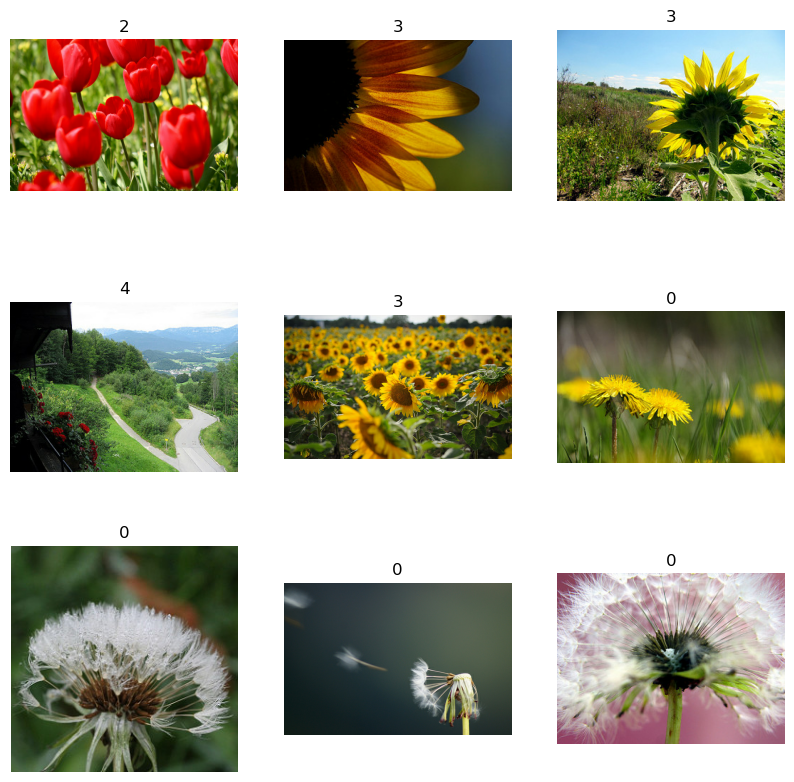

In [93]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    plt.imshow(images[0])
    # plt.title(metadata.features['label'].int2str(labels[0]))
    plt.axis("off")

In [94]:
metadata.features
# FeaturesDict({
#     'image': Image(shape=(None, None, 3), dtype=tf.uint8),
#     'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
# })


metadata.features['label']
# ClassLabel(shape=(), dtype=tf.int64, num_classes=5)


# Look at the labels
metadata.features['label'].names
# ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


# Look at how the classes are encoded
for label in metadata.features['label'].names:
  print(label,"," ,metadata.features['label'].str2int(label))

  
# Convert a encoded int label back to string
print(2,"," ,metadata.features['label'].int2str(2))
# 2 , tulips

dandelion , 0
daisy , 1
tulips , 2
sunflowers , 3
roses , 4
2 , tulips


In [95]:
print('Number of train examples', tf.data.experimental.cardinality(train_ds))
print('Number of validation examples', tf.data.experimental.cardinality(val_ds))
print('Number of test examples', tf.data.experimental.cardinality(test_ds))

# Number of train examples tf.Tensor(92, shape=(), dtype=int64)
# Number of validation examples tf.Tensor(12, shape=(), dtype=int64)
# Number of test examples tf.Tensor(12, shape=(), dtype=int64)


# Let's take a peak at a few images in the dataset
for x,y in train_ds.take(4):
  print(x.shape,y)
  
# (333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
# (212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
# (240, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
# (240, 320, 3) tf.Tensor(4, shape=(), dtype=int64)

Number of train examples tf.Tensor(2936, shape=(), dtype=int64)
Number of validation examples tf.Tensor(367, shape=(), dtype=int64)
Number of test examples tf.Tensor(367, shape=(), dtype=int64)
(333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
(212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(4, shape=(), dtype=int64)


2025-06-26 21:40:26.354418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [96]:
# Defining a few hyperparameters
IMG_SIZE = 150
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


# We can define the Resizing and Rescaling
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

# A function that resizes, rescales, batches and shuffles
def prepare_images(ds, shuffle=False,):
  
  # Resize and rescale the dataset.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # Shuffles the dataset
  if shuffle:
    ds = ds.shuffle(1000)
  
  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

## Let us resize and rescale the images in our dataset
train_ds = prepare_images(train_ds)
val_ds = prepare_images(val_ds)
test_ds = prepare_images(test_ds)

2025-06-26 21:42:21.851543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-26 21:42:21.930041: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


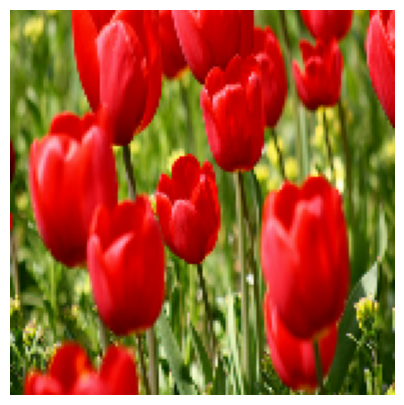

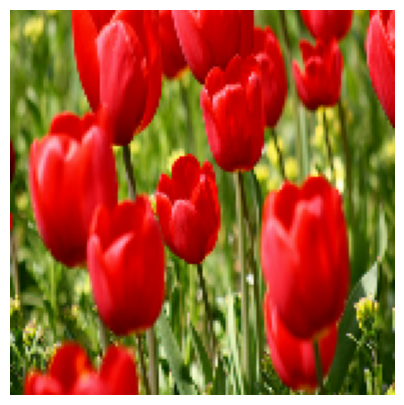

In [103]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    plt.imshow(images[0])
    # plt.title(metadata.features['label'].int2str(labels[0]))
    plt.axis("off")

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    plt.imshow(images[0])
    # plt.title(metadata.features['label'].int2str(labels[0]))
    plt.axis("off")

2025-06-26 21:44:36.033622: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


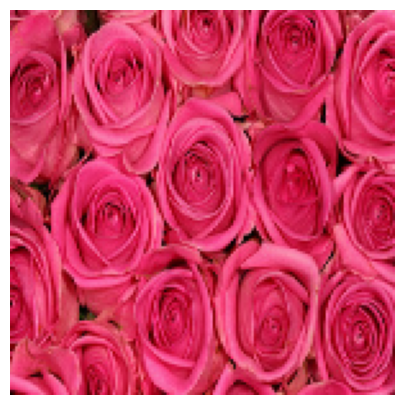

In [104]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(2):
    plt.imshow(images[0])
    plt.imshow(images[1])
    
    # plt.title(metadata.features['label'].int2str(labels[0]))
    plt.axis("off")

2025-06-26 21:40:26.762370: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Invalid shape (32, 150, 150, 3) for image data

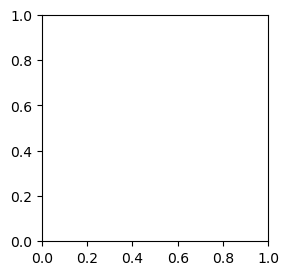

In [98]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")